In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import flax 
import flax.nn as nn

$\Delta x = f $ - Poisson equation

$Fx = f$ in matrix form


In [2]:

def P_local_matvec(k, K, w1, w2, x):
    x1 = x.reshape((2**k, -1))
    tmp = jnp.zeros(x1.shape)
    tmp = jax.ops.index_update(tmp, jax.ops.index[:-1, :], x1[1:, :])
    res = (x1@w1) + (tmp@w2)
    return res.flatten()


def P_local_matvec_t(k, K, w1, w2, x):
    x1 = x.reshape((2**k, -1))     #Can we make a 2D version
    tmp = jnp.zeros(x1.shape)
    tmp = jax.ops.index_update(tmp, jax.ops.index[1:, :], x1[:-1, :])
    res = x1@w1.T + (tmp@w2.T)

    return res.flatten()


class Projector_direct(nn.Module):
    def apply(self, x, k, K):
        s = (K-k)
        sp = (2**s, 1)
        w1 = self.param('w1', sp, nn.initializers.lecun_normal())
        w2 = self.param('w2', sp, nn.initializers.lecun_normal())
        x1 = x.reshape((2**k, -1))
        y = P_local_matvec(k, K, w1, w2, x1)
        z = P_local_matvec_t(k, K, w1, w2, y)
        z = z.reshape(x.shape)
        return z

In [3]:
def get_init_params(k, K):
    s = (K-k)
    xi = jnp.ones(2**s)
    eta = (jnp.arange(2**s) + 1)*1.0*(2**(-s))
    xi = jnp.reshape(xi, (-1, 1))
    eta = jnp.reshape(eta, (-1, 1))
    w1 = eta
    w2 = xi - eta
    w1 = w1*(2**(-s/2))
    w2 = w2*(2**(-s/2))
    return w1, w2

In [4]:
class BPX(nn.Module):
    def apply(self, x, K):
        y = jnp.zeros(x.shape)
        for k in range(K+1):
            scale = self.param('scale_{0:d}'.format(k), (1, ), nn.initializers.ones)
            y = y + 0.5*(scale + abs(scale))*Projector_direct(x, k, K)
        return y


def init_BPX(K, model):
    params = {}
    for k in range(K+1):
        name = 'Projector_direct_{0:d}'.format(k)
        scale_name = 'scale_{0:d}'.format(k)
        w1, w2 = get_init_params(k, K)
        loc_params = {'w1': w1, 'w2': w2}
        params[name] = loc_params
        params[scale_name] = jnp.reshape(2**(-k), (1, ))*0.05
        #params[scale_name] = jnp.reshape(2**(-k), (1, ))*1e-2

    return model.replace(params=params)

In [5]:
def loss(dpx_model, mat, x):
    sz = x.shape
    y = x
    dpx_model_batch = jax.vmap(dpx_model, 1, 1) 
    z = y
    for i in range(3):
        z = y.reshape(y.shape) 
        By = dpx_model_batch(z) 
        By = jnp.reshape(By, y.shape)
        By = mat@By 
        By = dpx_model_batch(By) 
        
        y = y - By 
    return jnp.mean(jnp.einsum('ib, ib->b', y, y))

In [6]:
rng = jax.random.PRNGKey(2010)
rng, key = jax.random.split(rng)

K = 5
B_cur = BPX.partial(K=K)
n = 2**K
x0 = jnp.ones(n)
_, init_params = B_cur.init(key, x0)
init_model = nn.Model(B_cur, init_params)
true_BPX_2 = init_BPX(K, init_model)

z = jnp.diag(jnp.ones(n-1), -1)
e = jnp.eye(n)
lp = 2*e - z - z.T
lp = lp*(n+1)**2



/Users/Anna.Rudenko/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [7]:
rng = jax.random.PRNGKey(2010)
rng, key = jax.random.split(rng)

K = 5
B_cur = BPX.partial(K=K)
n = 2**K
x0 = jnp.ones(n)
_, init_params = B_cur.init(key, x0)
init_model = nn.Model(B_cur, init_params)
true_BPX = init_BPX(K, init_model)

eye_mat = jnp.eye(n)


z = eye_mat.reshape((n, n))
batch_model = jax.vmap(true_BPX) #We want to have ||(I - tau*A*B)||->min
prec = batch_model(z)
print(prec.shape)

(32, 32)


In [8]:
xr =  jax.random.uniform(key, x0.shape)


In [9]:
f = jnp.ones_like(xr)*6

direct solution

In [11]:
gt = jnp.linalg.solve(lp, f)

Optimal parameter


$
\tau = \frac{2}{\lambda_{max} + \lambda_{min}}
$


In [12]:
w = jnp.linalg.eigvalsh(lp)

In [13]:
2/(max(w) + min(w))

0.0004591368227731864

In [14]:
eps = 1e-3
num_iter = 1e2

In [15]:
def richardson(F, x0, f, num_iter, tau =0.0004 , eps = 1e-3, P=None, PFP =False):
    conv = [x0]
    xk = x0
    for i in range(num_iter):
        if P == None:
            xk = xk - tau* (F @ xk - f)
            disp = jnp.linalg.norm( F @ xk - f)
        else:
            if PFP == False:
                xk = xk - tau * prec @ (F @ xk - f)
                disp = jnp.linalg.norm(F @ xk - f)             
            elif PFP == True:
                xk = xk - tau * (( prec @ (F @ (prec @ xk))) - (prec @ f))
                disp = jnp.linalg.norm((prec @ ( F @ (prec @ xk))) - (prec @ f))


        conv.append(xk)
    
        if disp <= eps:
            break
    return i, xk, disp, conv

In [16]:
i, ans, disp, conv = richardson(lp, xr, f, int(num_iter), eps=eps)

In [17]:
i_up, ans_up, disp_up, conv_up = richardson(lp, xr, f, int(num_iter),tau =.159 , eps=eps, P=prec,PFP= False)

In [18]:
i_up1, ans_up1, disp_up1, conv_up1 = richardson(lp, xr, f, int(num_iter),tau =7 , eps=eps, P=prec,PFP= True)

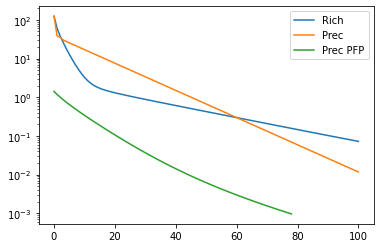

In [19]:
plt.semilogy([jnp.linalg.norm(lp @ x - f) / jnp.linalg.norm(f) for x in conv], label="Rich")
plt.semilogy([jnp.linalg.norm(lp @ x - f) / jnp.linalg.norm(f) for x in conv_up], label="Prec")
plt.semilogy([jnp.linalg.norm(prec @ (lp @ (prec @ x)) - prec @ f) for x in conv_up1], label="Prec PFP")
plt.legend()

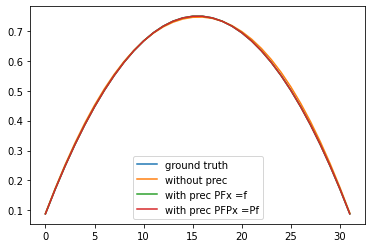

In [20]:
import matplotlib.pyplot as plt
plt.plot(gt, label = 'ground truth')
plt.plot(ans, label= 'without prec')
plt.plot(ans_up, label= 'with prec PFx =f')
plt.plot(prec@ans_up1, label ='with prec PFPx =Pf')
plt.legend()

In [21]:
r = open('bytesK5_3_.txt', 'rb')

In [22]:
l = r.readlines()
ll = b''.join(l)
params = flax.serialization.msgpack_restore(ll)
true_BPX_3 = true_BPX_2.replace(params=params)
n = 2**K

eye_mat = jnp.eye(n)

z = eye_mat.reshape((n, n))
batch_model = jax.vmap(true_BPX_3) #We want tob have ||(I - tau*A*B)||->min
prec2 = batch_model(z)
print(prec2.shape)

(32, 32)


In [23]:
i, ans, disp, conv = richardson(lp, xr, f, int(num_iter), eps=eps)

In [24]:
i_p, ans_p, disp_p, conv_p = richardson(lp, xr, f, int(num_iter),tau =.026 , eps=eps, P=prec2,PFP= False)

In [25]:
i_p1, ans_p1, disp_p1, conv_p1 = richardson(lp, xr, f, int(num_iter),tau =.767 , eps=eps, P=prec2,PFP= True)

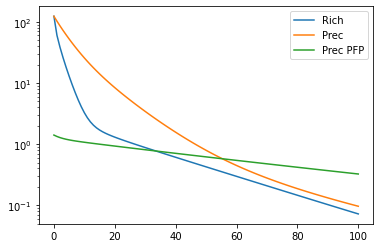

In [26]:
plt.semilogy([jnp.linalg.norm(lp @ x - f) / jnp.linalg.norm(f) for x in conv], label="Rich")
plt.semilogy([jnp.linalg.norm(lp @ x - f) / jnp.linalg.norm(f) for x in conv_p], label="Prec")
plt.semilogy([jnp.linalg.norm(prec @ (lp @ (prec @ x)) - prec @ f) for x in conv_p1], label="Prec PFP")
plt.legend()

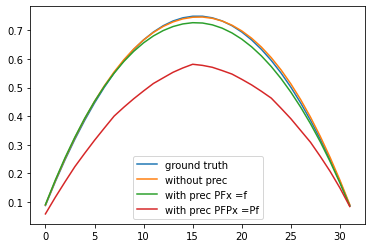

In [27]:
import matplotlib.pyplot as plt
plt.plot(gt, label = 'ground truth')
plt.plot(ans, label= 'without prec')
plt.plot(ans_p, label= 'with prec PFx =f')
plt.plot(prec@ans_p1, label ='with prec PFPx =Pf')
plt.legend()

In [57]:
w2, _ = jnp.linalg.eig(prec2@lp@prec2)
2/(max(w2)+min(w2))

(0.767494972942914+0j)